<a href="https://colab.research.google.com/github/mcarhuasn/DIA2022-VisionArtif-ClasificacionCOVID/blob/master/Proyecto_Clasificacion_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h1><font color="#113D68" size=5.5>Proyecto: Clasificación de Pacientes con COVID-9 usando imágenes de Rayos X</font></h1>**

<h1><font color="#113D68" size=5>Curso: Desarrollo de Aplicaciones con Visión Artificial</font></h1>

<h1><font color="#113D68" size=4>Docentes: Dr. Analí Alfaro Alfaro, Mg. Alaín Alejo Huarachi</font></h1>

<h1><font color="#113D68" size=4>Grupo:

- Milton Carhuas Ñañez

- Carlos Incasoller Vilca

</font></h1>

<a id="section23"></a>
## <font color="#004D7F"> Importación de Librerías</font>

In [38]:
import torchvision
from PIL import Image
import torchvision.transforms as T
import cv2
import plotly.express as px
import plotly.subplots as subplots
import plotly.graph_objects as go
import os, sys, time, datetime, random

import os
import shutil

import pandas as pd
import numpy as np

# importando librerías
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import plotly.express as px
import time
import copy

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. RECUPERACIÓN DE INFORMACIÓN</font>

#### Creación de variables para directorios y archivos

In [12]:
# Directorios
DIR_PROY = '/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA'
DIR_REPOS_PROY = DIR_PROY + '/covid-chestxray-dataset'
DIR_METADATA = DIR_REPOS_PROY + '/'
DIR_DATA = DIR_REPOS_PROY + '/images'
DIR_COVID = DIR_DATA + "/covid"
DIR_NO_COVID = DIR_DATA + "/no-covid"

# Archivos
FILE_METADATA = 'metadata.csv'

#### Habilitar acceso a directorios de Google Drive

In [4]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [5]:
!pwd

/content


In [6]:
!ls -ltrh /content/

total 8.0K
drwxr-xr-x 1 root root 4.0K Jun 15 13:42 sample_data
drwx------ 6 root root 4.0K Jun 29 22:15 drive


In [7]:
%cd "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/"

/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA


In [6]:
# Este bloque de celda se ejecuta una sola vez

# Debe ser ejecutado una sola vez para copiar el repositorio GitHub en Google Drive en el directorio Proyecto_VA
#! git clone https://github.com/ieee8023/covid-chestxray-dataset

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 17.62 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Checking out files: 100% (1174/1174), done.


In [8]:
# Tamaño del directorio de imagenes
!du -h "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images"

289M	/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/covid
238M	/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/no-covid
526M	/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images


In [9]:
# Cantidad de elementos del directorio de imagenes
!ls "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images" | wc -l

2


In [10]:
# Tipos de archivo del directorio de imagenes
!find "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images" -type f | awk -F. '!a[$NF]++{print $NF}'

jpg
jpeg
png
PNG
JPG


#### Importación de Metadata (Etiqueta por cada Imagen)

In [13]:
df_metadata = pd.read_csv(DIR_METADATA + FILE_METADATA, sep=',')
print('Tamaño del conjunto de datos: ', df_metadata.shape)
df_metadata.head(5)

Tamaño del conjunto de datos:  (950, 30)


patientid  offset sex   age                   finding RT_PCR_positive  \
0         2     0.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
1         2     3.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
2         2     5.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
3         2     6.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
4         4     0.0   F  52.0  Pneumonia/Viral/COVID-19               Y   

  survival intubated intubation_present went_icu  ...              date  \
0        Y         N                  N        N  ...  January 22, 2020   
1        Y         N                  N        N  ...  January 25, 2020   
2        Y         N                  N        N  ...  January 27, 2020   
3        Y         N                  N        N  ...  January 28, 2020   
4      NaN         N                  N        N  ...  January 25, 2020   

                                            location  folder  \
0        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
1        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
2        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
3        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
4  Changhua Christian Hospital, Changhua City, Ta...  images   

                                            filename                   doi  \
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
1  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
2  auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
3  auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
4                              nejmc2001573_f1a.jpeg  10.1056/NEJMc2001573   

                                                 url  license  \
0  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
1  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
2  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
3  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
4  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   

                                      clinical_notes other_notes Unnamed: 29  
0  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
1  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
2  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
3  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
4   diffuse infiltrates in the bilateral lower lungs         NaN         NaN  

[5 rows x 30 columns]

In [14]:
# Cantidad de imágenes para enfermedad del tipo COVID-9
df_metadata[df_metadata["finding"]=='Pneumonia/Viral/COVID-19'].shape

(584, 30)

In [15]:
# Cantidad de imágenes por tipo de enfermedad
pd.DataFrame(df_metadata["finding"].value_counts(dropna=False))

finding
Pneumonia/Viral/COVID-19                     584
todo                                          83
Pneumonia                                     81
Pneumonia/Fungal/Pneumocystis                 30
Pneumonia/Bacterial/Streptococcus             22
No Finding                                    22
Tuberculosis                                  18
Pneumonia/Viral/SARS                          16
Pneumonia/Lipoid                              13
Pneumonia/Bacterial/Mycoplasma                11
Pneumonia/Viral/MERS-CoV                      10
Pneumonia/Bacterial/Klebsiella                10
Pneumonia/Bacterial/Legionella                10
Pneumonia/Bacterial/Nocardia                   8
Pneumonia/Viral/Varicella                      6
Pneumonia/Viral/Influenza                      5
Pneumonia/Bacterial                            4
Pneumonia/Bacterial/E.Coli                     4
Pneumonia/Viral/Herpes                         3
Pneumonia/Bacterial/Chlamydophila              3
Pneumonia/Viral/Influenza/H1N1                 2
Pneumonia/Fungal/Aspergillosis                 2
Unknown                                        1
Pneumonia/Aspiration                           1
Pneumonia/Bacterial/Staphylococcus/MRSA        1

In [16]:
# Cantidad de imágenes por tipo de carpeta
pd.DataFrame(df_metadata["folder"].value_counts(dropna=False))

folder
images      929
volumes      21

#### Creación de Variable Objetivo

In [17]:
df_metadata['label'] = [1 if x == 'Pneumonia/Viral/COVID-19' else 0 for x in df_metadata['finding']]
print(df_metadata.shape)
df_metadata[['finding','folder','filename','label']].head(5)

(950, 31)


finding  folder  \
0  Pneumonia/Viral/COVID-19  images   
1  Pneumonia/Viral/COVID-19  images   
2  Pneumonia/Viral/COVID-19  images   
3  Pneumonia/Viral/COVID-19  images   
4  Pneumonia/Viral/COVID-19  images   

                                            filename  label  
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...      1  
1  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...      1  
2  auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...      1  
3  auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...      1  
4                              nejmc2001573_f1a.jpeg      1

#### Definición de Universo

In [18]:
pd.set_option('display.max_colwidth',-1)

df_metadata_u = df_metadata.copy()
df_metadata_u = df_metadata_u[['finding','folder','filename','label']][df_metadata["folder"]=='images']
print('Tamaño del conjunto de datos: ', df_metadata_u.shape)
df_metadata_u.head(5)

Tamaño del conjunto de datos:  (929, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


finding  folder  \
0  Pneumonia/Viral/COVID-19  images   
1  Pneumonia/Viral/COVID-19  images   
2  Pneumonia/Viral/COVID-19  images   
3  Pneumonia/Viral/COVID-19  images   
4  Pneumonia/Viral/COVID-19  images   

                                                                 filename  \
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg   
1  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg   
2  auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg   
3  auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg   
4  nejmc2001573_f1a.jpeg                                                    

   label  
0  1      
1  1      
2  1      
3  1      
4  1

In [19]:
# Cantidad de imágenes por tipo de enfermedad para Universo
pd.DataFrame(df_metadata_u["finding"].value_counts(dropna=False))

finding
Pneumonia/Viral/COVID-19                 563    
todo                                     83     
Pneumonia                                81     
Pneumonia/Fungal/Pneumocystis            30     
Pneumonia/Bacterial/Streptococcus        22     
No Finding                               22     
Tuberculosis                             18     
Pneumonia/Viral/SARS                     16     
Pneumonia/Lipoid                         13     
Pneumonia/Bacterial/Mycoplasma           11     
Pneumonia/Viral/MERS-CoV                 10     
Pneumonia/Bacterial/Klebsiella           10     
Pneumonia/Bacterial/Legionella           10     
Pneumonia/Bacterial/Nocardia             8      
Pneumonia/Viral/Varicella                6      
Pneumonia/Viral/Influenza                5      
Pneumonia/Bacterial                      4      
Pneumonia/Bacterial/E.Coli               4      
Pneumonia/Viral/Herpes                   3      
Pneumonia/Bacterial/Chlamydophila        3      
Pneumonia/Viral/Influenza/H1N1           2      
Pneumonia/Fungal/Aspergillosis           2      
Unknown                                  1      
Pneumonia/Aspiration                     1      
Pneumonia/Bacterial/Staphylococcus/MRSA  1

#### Clasificación de imágenes por clase (COVID / NO-COVID)

In [31]:
# Este bloque de celda se ejecuta una sola vez

# # DIR_COVID = DIR_DATA + "covid/"
# # DIR_NO_COVID = DIR_DATA + "no-covid/"

# os.mkdir(DIR_COVID)
# print("Directory '% s' created" % DIR_COVID)

# os.mkdir(DIR_NO_COVID)
# print("Directory '% s' created" % DIR_NO_COVID)

Directory '/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/covid/' created
Directory '/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/no-covid/' created


In [ ]:
# Este bloque de celda se ejecuta una sola vez

# count = 0

# for path, dirs, files in os.walk(DIR_DATA):
#   for filename in files:
#     #print(os.path.join(filename))
#     #print(filename)
#     dir_orig = os.path.join(DIR_DATA, filename)

#     for idx, row in df_metadata_u.iterrows():
#       if row['filename'] == filename and row['label'] == 1:
#         count = count + 1
#         #print('Indice DF: ', idx, ' | Imagen COVID: ', row['filename'], ' $ ' , filename, ' | Contador: ', count)

#         shutil.move(dir_orig, DIR_COVID)
#       elif row['filename'] == filename and row['label'] != 1:
#         shutil.move(dir_orig, DIR_NO_COVID)

# print('Cantidad de imagenes COVID movidas a nueva carpeta: ', count)

In [20]:
# Cantidad de archivos en carpeta "covid"
!ls "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/covid" | wc -l

563


In [21]:
# Cantidad de archivos en carpeta "covid"
!ls "/content/drive/MyDrive/Diplomado-Dev-Aplic-IA/05_Des_Aplic_VisionArtificial/Proyecto_VA/covid-chestxray-dataset/images/no-covid" | wc -l

366


---
<a id="section0"></a>
# <font color="#004D7F" size=6> 1. COMPRENSIÓN DEL NEGOCIO</font>

Colección de dataset de imágenes de COVID-9:

https://github.com/ieee8023/covid-chestxray-dataset

---
<a id="section0"></a>
# <font color="#004D7F" size=6>2. COMPRENSIÓN DE LOS DATOS</font>

<a id="section23"></a>
## <font color="#004D7F"> 2.1. Importación de Datos</font>

In [47]:
# Definiendo el dataset
dataset = datasets.ImageFolder(DIR_DATA,
                              transform=transforms.Compose([
                                  #transforms.RandomResizedCrop(224),
                                  transforms.Resize(255),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
                                  ]))

class_names = dataset.classes

print('Tamaño del conjunto de datos total: ', len(dataset))
print('Clases de la variable objetivo: ', class_names)

Tamaño del conjunto de datos total:  929
Clases de la variable objetivo:  ['covid', 'no-covid']


In [48]:
# Imagen de Muestra
dataset[0][0]

tensor([[[0.7591, 0.7591, 0.7933,  ..., 0.4679, 0.4679, 0.4508],
         [0.7591, 0.7762, 0.7933,  ..., 0.5536, 0.5193, 0.4508],
         [0.7933, 0.8447, 0.8104,  ..., 0.6392, 0.5364, 0.5022],
         ...,
         [0.4851, 0.4337, 0.4679,  ..., 0.6734, 0.6049, 0.5878],
         [0.5022, 0.4851, 0.5022,  ..., 0.6563, 0.5707, 0.5878],
         [0.5193, 0.5193, 0.4851,  ..., 0.6392, 0.6392, 0.6563]],

        [[0.9055, 0.9055, 0.9405,  ..., 0.6078, 0.6078, 0.5903],
         [0.9055, 0.9230, 0.9405,  ..., 0.6954, 0.6604, 0.5903],
         [0.9405, 0.9930, 0.9580,  ..., 0.7829, 0.6779, 0.6429],
         ...,
         [0.6254, 0.5728, 0.6078,  ..., 0.8179, 0.7479, 0.7304],
         [0.6429, 0.6254, 0.6429,  ..., 0.8004, 0.7129, 0.7304],
         [0.6604, 0.6604, 0.6254,  ..., 0.7829, 0.7829, 0.8004]],

        [[1.1237, 1.1237, 1.1585,  ..., 0.8274, 0.8274, 0.8099],
         [1.1237, 1.1411, 1.1585,  ..., 0.9145, 0.8797, 0.8099],
         [1.1585, 1.2108, 1.1759,  ..., 1.0017, 0.8971, 0.

In [52]:
print('Tipo de datos del 1er elemento del dataset: ', type(dataset[0])) # tupla(0 => tensor, 1 => label)
print('Tamaño del 1er elemento del dataset: ', len(dataset[0])) # tupla(0 => tensor, 1 => label)

# Dimensiones para una imagen de muestra (indice = 0)
print('Dimension de la imagen del 1er elemento: ', dataset[0][0].shape) # dimension del tensor
print(f'Label del 1er elemento = {dataset[0][1]}') # label

Tipo de datos del 1er elemento del dataset:  <class 'tuple'>
Tamaño del 1er elemento del dataset:  2
Dimension de la imagen del 1er elemento:  torch.Size([3, 224, 224])
Label del 1er elemento = 0


<a id="section23"></a>
## <font color="#004D7F"> 2.3. Análisis Exploratorio de Datos</font>

In [28]:
# Mostramos algunos ejemplos
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  fig = px.imshow(inp, title=title)
  fig.update_layout(title_x=.5)
  fig.show()

Numero de batch: 0
Tamaño del batch de imagenes: torch.Size([4, 3, 224, 224])
Tamaño del batch de targets : torch.Size([4])



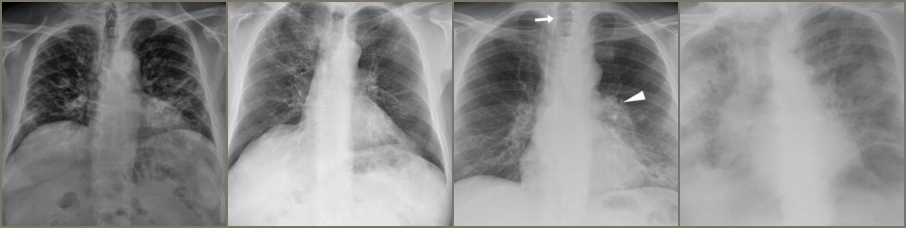

In [41]:
dataset_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Crear un iterador sobre la lista de batches
examples = enumerate(dataset_loader)

 # Obtener el siguiente batch del iterador
batchId, (exampleData_inputs, exampleTargets_classes) = next(examples)
print(f'Numero de batch: {batchId}')
print(f'Tamaño del batch de imagenes: {exampleData_inputs.shape}')
print(f'Tamaño del batch de targets : {exampleTargets_classes.shape}')

#inputs, classes = next(iter(dataset_loader))
exampleData_inputs, exampleTargets_classes = next(iter(dataset_loader))
#out = torchvision.utils.make_grid(inputs)
out = torchvision.utils.make_grid(exampleData_inputs)

imshow(out, title=', '.join(str(class_names[x]) for x in exampleTargets_classes))

In [44]:
# Mostramos los primeros 16 elementos del batch con su etiqueta
fig = subplots.make_subplots(1, 4, subplot_titles=[f'Groundtruth: {exampleTargets_classes[i]}' for i in range(4)])

for i in range(4):
  row = i//4 + 1
  col = i%4 + 1
  fig.add_trace(px.imshow(exampleData_inputs[i][0]).data[0], row, col)

fig.update_yaxes(autorange='reversed')
fig.update_xaxes(scaleanchor='y',scaleratio=1)
fig.update_layout(coloraxis=dict(colorscale='gray_r'))
fig.show()

---
<a id="section0"></a>
# <font color="#004D7F" size=6>3. PREPARACIÓN DE LOS DATOS</font>

<a id="section0"></a>
# <font color="#004D7F" size=6>4. MODELADO DE LOS DATOS</font>

<a id="section0"></a>
# <font color="#004D7F" size=6>5. EVALUACIÓN</font>